In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from atusfunclib import load_data
from activitylib import ACTINFO
from wlmetrics import *
import pickle
from datetime import date

In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn import model_selection
from sklearn.externals import joblib

In [5]:
# Import all csv data
data_import = load_data(loc="data", loc_clean="cleaned_data", loc_codes="code_tables")

In [6]:
# Unpack individual dataframes
df, dfactcodes, dfeducodes, dfinccodes, dfagecodes, \
dfempcodes, dfindcodes, dfraccodes, dfloccodes, dfwhocodes, \
dfdemocodes = data_import

In [7]:
# Convert category columns to float
df['TEAGE_CAT'] = df['TEAGE_CAT'].astype(float)
df['TRERNWA_CAT'] = df['TRERNWA_CAT'].astype(float)

In [8]:
df.filter(regex=r'TUCASEID|^t.+[^W]$').head()

,TUCASEID,t010101,t010102,t010199,t010201,t010299,t010301,t010399,t010401,t010499,...,t09,t10,t11,t12,t13,t14,t15,t16,t18,t50
0,20030100013280,870,0,0,40,0,0,0,0,0,...,0,0,5,325,200,0,0,0,0,0
1,20030100013344,620,0,0,60,0,0,0,0,0,...,0,0,90,590,0,0,0,0,20,0
2,20030100013352,560,0,0,80,0,0,0,0,0,...,0,0,75,340,0,0,0,60,10,0
3,20030100013848,720,0,0,35,0,0,0,0,0,...,0,0,25,265,0,0,0,0,0,0
4,20030100014165,385,0,0,75,0,0,0,0,0,...,0,0,92,60,60,0,0,0,78,0


In [9]:
df.filter(regex=r'^[^t]').head()

,TUCASEID,TEAGE,TESEX,TUYEAR,TRHOLIDAY,TUDIARYDAY,GEMETSTA,GTMETSTA,TEHRUSLT,TELFS,...,TRERNHLY,TRERNWA,TRERNWA_CAT,GESTFIPS,TEHRUSLT_W,TEAGE_W,TRCHILDNUM_W,TRNUMHOU_W,TRERNHLY_W,TRERNWA_W
0,20030100013280,60,1,2003,0,6,1.0,NaN,30.0,2,...,22.0,660.0,4.0,6,2.446639e+08,4.893278e+08,0.000000e+00,2.446639e+07,1.794202e+08,5.382605e+09
1,20030100013344,41,2,2003,0,7,2.0,NaN,30.0,1,...,NaN,200.0,1.0,6,5.205968e+07,7.114822e+07,3.470645e+06,6.941290e+06,NaN,3.470645e+08
2,20030100013352,26,2,2003,0,7,1.0,NaN,12.0,2,...,12.5,200.0,1.0,6,4.596633e+07,9.959371e+07,0.000000e+00,7.661055e+06,4.788159e+07,7.661055e+08
3,20030100013848,36,2,2003,0,5,2.0,NaN,NaN,4,...,NaN,NaN,NaN,13,NaN,2.383928e+08,1.324405e+07,2.648809e+07,NaN,NaN
4,20030100014165,51,1,2003,0,5,2.0,NaN,80.0,1,...,NaN,NaN,NaN,21,2.454710e+08,1.564878e+08,6.136775e+06,1.227355e+07,NaN,NaN


In [10]:
# Activity names dictionary
activities_dict = ACTINFO['activities_n_dict']
activities_dict_sh = ACTINFO['activities_n_dict_inter_short']

In [13]:
def clusterOptimizer(X, prescale=1.0, nc=range(3, 16), batch_size=None, sample_size=5000, random_state=42, opt='ss'):
    X = X / prescale
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    print "{} samples, {} features".format(*X_scaled.shape)
    
    ss = []
    ch = []
    for n in nc:
        if batch_size:
            k_means_activity = MiniBatchKMeans(n_clusters=n, batch_size=batch_size, random_state=random_state)
        else:
            k_means_activity = KMeans(n_clusters=n, random_state=random_state)
        k_means_activity.fit(X_scaled)
        y = k_means_activity.predict(X_scaled)
        
        sindex = metrics.silhouette_score(X_scaled, y, sample_size=sample_size, random_state=random_state)
        chindx = metrics.calinski_harabaz_score(X_scaled, y)
        
        ss.append(sindex)
        ch.append(chindx)
        print "  for {:2d} clusters, S={}, CH={}".format(n, sindex, chindx)
        
    if opt == 'ss':
        nc_optimum = nc[np.argmax(ss)]
    elif opt == 'ch':
        nc_optimum = nc[np.argmax(ch)]
        
    print "optimum clusters = {}".format(nc_optimum)
    
    if batch_size:
        k_means_activity_opt = MiniBatchKMeans(n_clusters=nc_optimum, batch_size=batch_size, random_state=random_state)
    else:    
        k_means_activity_opt = KMeans(n_clusters=nc_optimum, random_state=random_state)
    k_means_activity_opt.fit(X_scaled)
    y_opt = k_means_activity_opt.predict(X_scaled)
    
    sindex = metrics.silhouette_score(X_scaled, y_opt, sample_size=sample_size, random_state=random_state)
    chindx = metrics.calinski_harabaz_score(X_scaled, y_opt)
    
    print "metrics:"
    print "  silhouette score         {}".format(sindex)
    print "  calinski-harabaz index   {}".format(chindx)
    
    result = scaler.inverse_transform(k_means_activity_opt.cluster_centers_) * prescale
    
    return result, ss, ch, k_means_activity_opt, nc_optimum

In [14]:
# Clustering activity times with KMeans

In [15]:
PRESCALE = 10.0
RANDSTATE = 142

In [16]:
X_wehol = df[(df['TRHOLIDAY'] == 1) | (df['TRWEEKEND'] == 1)][ACTINFO['activities_t']]
X_weday = df[(df['TRHOLIDAY'] == 0) & (df['TRWEEKEND'] == 0)][ACTINFO['activities_t']]

In [17]:
result_wehol, ss_wehol, ch_wehol, model_wehol, nopt_wehol = clusterOptimizer(X_wehol,
                                                                   prescale=PRESCALE,
                                                                   nc=range(4, 7),
                                                                   batch_size=None,
                                                                   sample_size=10000,
                                                                   random_state=RANDSTATE,
                                                                   opt='ss')

87293 samples, 33 features
  for  4 clusters, S=0.097254160369, CH=4167.38378812
  for  5 clusters, S=0.102747623484, CH=3808.32048246
  for  6 clusters, S=0.0893546878761, CH=3610.89221109
optimum clusters = 5
metrics:
  silhouette score         0.102747623484
  calinski-harabaz index   3808.32048246


In [18]:
# Pickle chosen model
joblib.dump(model_wehol, 'models/kmeans_model_atus_wehol_{}_n{}_{}.pkl'.format(RANDSTATE, nopt_wehol, date.today()))

['models/kmeans_model_atus_wehol_142_n5_2017-10-13.pkl']

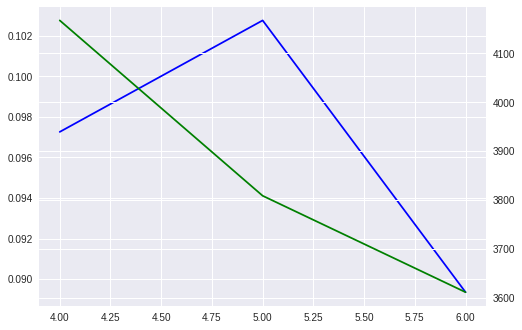

In [19]:
# Plot clustering scores
x = range(4, 7)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, ss_wehol, 'b')
ax2.plot(x, ch_wehol, 'g')

In [20]:
result_df_wehol = pd.DataFrame(result_wehol, columns=ACTINFO['activities_t'])

In [21]:
pd.options.display.float_format = '{:.4f}'.format
result_df_wehol[["t"+a for a in ACTINFO['positiveWL']]]

,t010101,t0102,t0103,t050201,t050203,t1101,t1201,t1202,t1203,t1204,t1301,t1302,t14
0,530.9352,30.5347,1.3420,0.0205,-0.0000,76.2224,41.3809,8.8977,148.6279,5.5261,12.1542,2.0210,13.4828
1,474.5790,45.1817,0.5095,0.4922,0.0444,56.8357,27.2250,5.1416,137.0209,3.6419,8.6875,1.1223,5.9871
2,594.7682,24.5728,10.8189,0.0205,0.0003,60.0014,28.5279,2.3765,409.1043,2.4135,12.7580,0.6912,10.7057
3,475.0000,18.3333,1.6667,0.0000,0.0000,68.3333,130.0000,0.0000,224.6667,0.0000,0.0000,0.0000,0.0000
4,533.6394,55.6605,1.2989,0.0197,0.0161,86.5964,92.0893,23.0278,161.7274,20.1103,32.4905,6.6764,39.1780


In [22]:
result_df_wehol[["t"+a for a in ACTINFO['negoccWL']]]

,t05,t0501,t0504,t1805
0,17.4893,15.3717,1.1229,1.0494
1,489.3451,481.4412,1.1675,38.0708
2,11.2600,9.2126,0.7802,0.6023
3,0.0000,0.0000,0.0000,0.0000
4,13.6879,11.8292,0.4726,1.0344


In [24]:
result_df_wehol[["t"+a for a in ACTINFO['neghomeWL']]]

,t0201,t0202,t0203,t0204,t0209,t0301,t0302,t0303,t0304,t0305,t0802,t0803
0,67.8655,84.7613,5.7815,3.3203,11.0052,215.7601,10.0150,4.9154,0.3872,0.7422,0.1038,0.0000
1,17.6135,16.2722,2.0400,1.3559,5.5103,12.6050,0.4827,0.1647,0.2615,0.3853,0.1275,0.0009
2,60.0172,40.2506,9.2295,7.8515,8.1733,6.3770,0.1561,0.1201,1.3655,0.2949,0.1087,0.0018
3,68.3333,100.0000,0.0000,-0.0000,101.6667,10.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,165.0000
4,36.1414,29.8486,4.4237,2.4759,20.7658,12.0914,0.2546,0.1189,0.5051,1.1676,0.4446,0.0003


In [25]:
result_df_wehol[["t"+a for a in ACTINFO['neutral']]]

,t06,t07,t09,t18
0,4.9604,31.7902,0.5210,57.1575
1,4.6794,13.8728,0.3695,73.8200
2,8.5065,18.7531,0.3287,30.7412
3,0.0000,13.3333,0.0000,42.0000
4,9.7455,52.3344,1.1430,119.7452


In [26]:
result_weday, ss_weday, ch_weday, model_weday, nopt_weday = clusterOptimizer(X_weday,
                                                                   prescale=PRESCALE,
                                                                   nc=range(5, 10),
                                                                   batch_size=None,
                                                                   sample_size=10000,
                                                                   random_state=RANDSTATE,
                                                                   opt='ss')

83549 samples, 33 features
  for  5 clusters, S=0.16015034234, CH=3913.84616942
  for  6 clusters, S=0.163000497138, CH=3830.36708553
  for  7 clusters, S=0.16732210777, CH=3636.02017164
  for  8 clusters, S=0.156599242138, CH=3454.77336884
  for  9 clusters, S=0.148586745113, CH=3413.54313492
optimum clusters = 7
metrics:
  silhouette score         0.16732210777
  calinski-harabaz index   3636.02017164


In [27]:
# Pickle chosen model
joblib.dump(model_weday, 'models/kmeans_model_atus_weday_{}_n{}_{}.pkl'.format(RANDSTATE, nopt_weday, date.today()))

['models/kmeans_model_atus_weday_142_n7_2017-10-13.pkl']

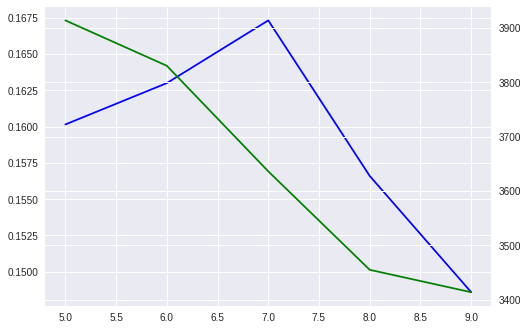

In [29]:
# Plot clustering scores
x = range(5, 10)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, ss_weday, 'b')
ax2.plot(x, ch_weday, 'g')

In [30]:
result_df_weday = pd.DataFrame(result_weday, columns=ACTINFO['activities_t'])

In [31]:
pd.options.display.float_format = '{:.4f}'.format
result_df_weday[["t"+a for a in ACTINFO['positiveWL']]]

,t010101,t0102,t0103,t050201,t050203,t1101,t1201,t1202,t1203,t1204,t1301,t1302,t14
0,503.4126,32.5846,2.2277,0.0000,0.0000,63.0776,27.6759,1.7915,169.0974,1.1177,10.6648,0.0793,4.9679
1,453.2071,47.0896,0.7437,0.2024,0.0538,60.5774,17.5688,1.5696,126.4720,1.4374,10.4831,0.0873,2.3296
2,575.2597,27.5695,19.8470,0.0000,-0.0000,60.3324,25.1228,0.7691,443.5130,0.6696,12.8859,0.0433,4.1381
3,499.4106,50.6533,2.6327,0.0211,0.0000,82.1208,81.4041,7.7203,182.1968,15.2731,32.5022,0.1016,11.0560
4,490.1730,49.6712,0.3646,0.0119,0.0305,54.1680,28.7962,3.2488,131.5488,2.4740,29.0188,0.4748,2.7258
5,521.1860,52.9070,7.2326,-0.0000,0.0000,73.4884,36.7674,-0.0000,156.4884,0.2326,4.5349,0.0000,4.3023
6,455.9287,48.0548,0.6527,0.4936,-0.0000,58.3400,26.3254,2.4735,111.8739,2.0567,21.2486,166.0658,1.3949


In [32]:
result_df_weday[["t"+a for a in ACTINFO['negoccWL']]]

,t05,t0501,t0504,t1805
0,37.5405,33.4971,2.7691,2.6980
1,520.9833,517.9022,0.4864,43.0702
2,21.7330,14.1917,5.5380,1.6805
3,34.7857,30.3540,2.8502,3.5025
4,39.4261,36.3413,0.9801,3.3800
5,81.2093,68.6512,7.7907,10.6279
6,222.4442,219.1097,1.5082,15.0804


In [34]:
result_df_weday[["t"+a for a in ACTINFO['neghomeWL']]]

,t0201,t0202,t0203,t0204,t0209,t0301,t0302,t0303,t0304,t0305,t0802,t0803
0,150.5478,105.7237,3.3776,1.7853,12.9738,129.3817,19.9119,6.2879,1.9058,0.9088,0.4148,0.0110
1,12.2367,20.9860,1.7102,1.0544,6.8286,21.7039,2.7783,0.3581,0.3865,0.3486,0.2992,0.0094
2,31.4591,30.9149,7.9994,7.9035,9.7116,5.7019,0.5314,0.1558,0.9078,0.3728,0.2953,0.0070
3,34.8166,30.1254,4.1444,2.6429,36.1176,15.0331,0.9313,0.5262,4.3549,2.0043,2.3281,0.0382
4,8.0978,10.7308,0.5148,0.3924,6.4489,9.3415,0.8606,0.0599,0.2480,0.4907,0.0866,-0.0000
5,44.8837,48.3721,0.0000,1.1628,24.1628,34.8605,4.6512,0.3488,1.2791,0.8140,1.2791,97.7209
6,21.9049,16.8830,1.1243,1.6654,9.9159,19.4333,2.2340,0.5393,0.3565,0.2706,0.6197,0.0000


In [35]:
result_df_weday[["t"+a for a in ACTINFO['neutral']]]

,t06,t07,t09,t18
0,4.1941,24.4819,0.7494,52.6799
1,3.3598,10.0014,0.4297,79.3403
2,3.0937,12.5374,0.7078,33.8021
3,5.1445,62.6116,4.4931,130.3341
4,451.1277,7.4221,0.1916,71.5204
5,6.2791,32.4651,3.4884,116.4419
6,76.1645,15.4150,0.7239,111.5759


In [45]:
# Plot some examples of group activities

In [49]:
result_df_wehol_norm = pd.DataFrame(normalize(result_df_wehol, axis=0), columns=ACTINFO['activities_t']).transpose()
result_df_weday_norm = pd.DataFrame(normalize(result_df_weday, axis=0), columns=ACTINFO['activities_t']).transpose()

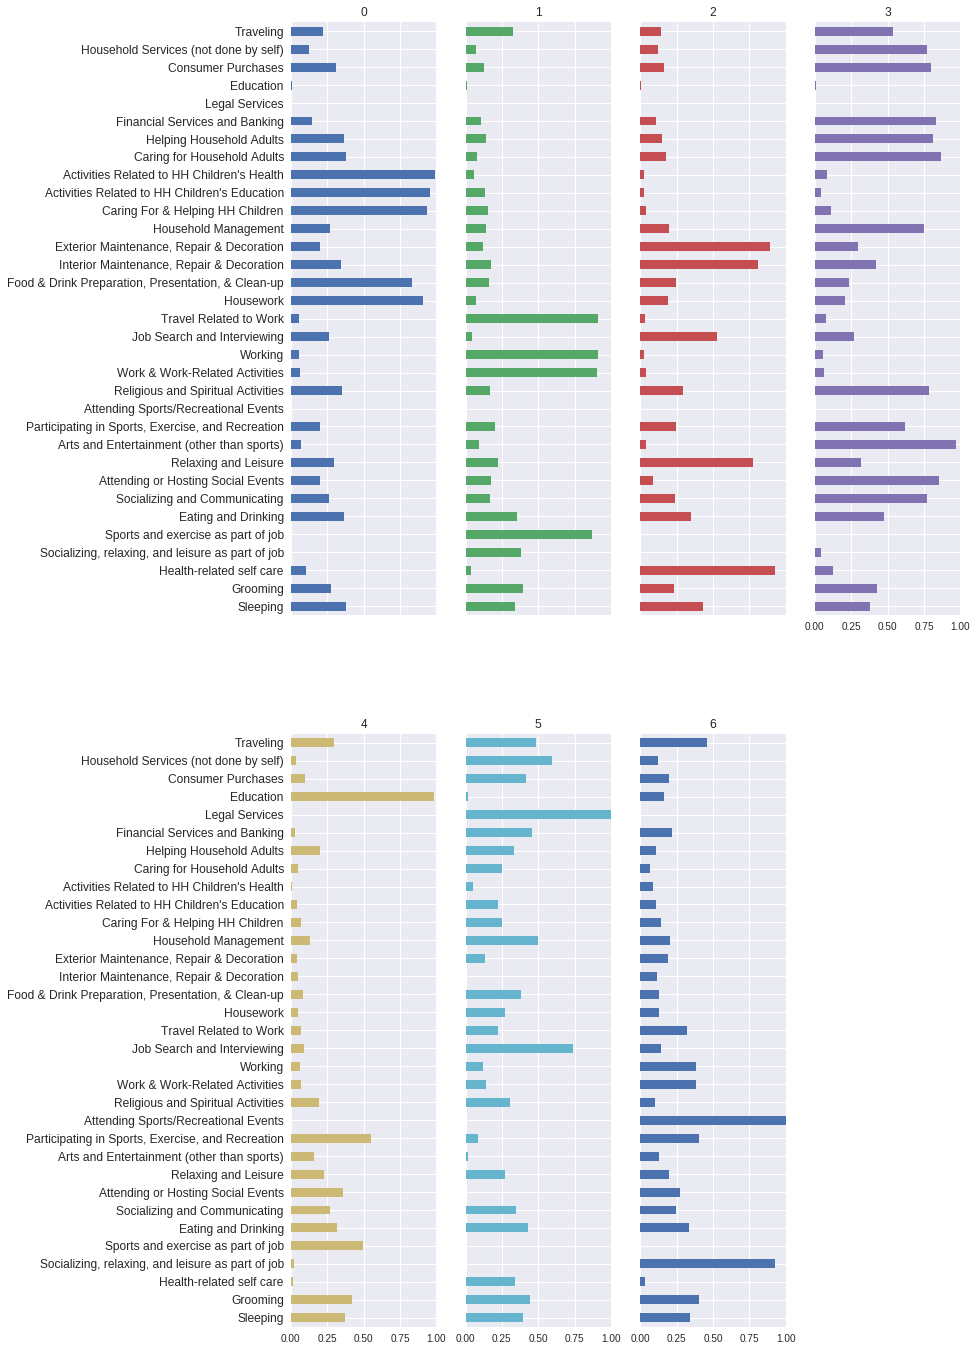

In [38]:
plots = result_df_weday_norm.plot(kind='barh',
                                  subplots=True,
                                  layout=(2,4),
                                  figsize=(12,24),
                                  legend=False,
                                  sharey=True)
for r in plots:
    r[0].set_yticklabels([activities_dict[a] for a in ACTINFO['activities']], fontsize=12)
    for p in r:
        p.set(xlim=[0,1])
#plt.savefig('', bbox_inches='tight')
plt.show()

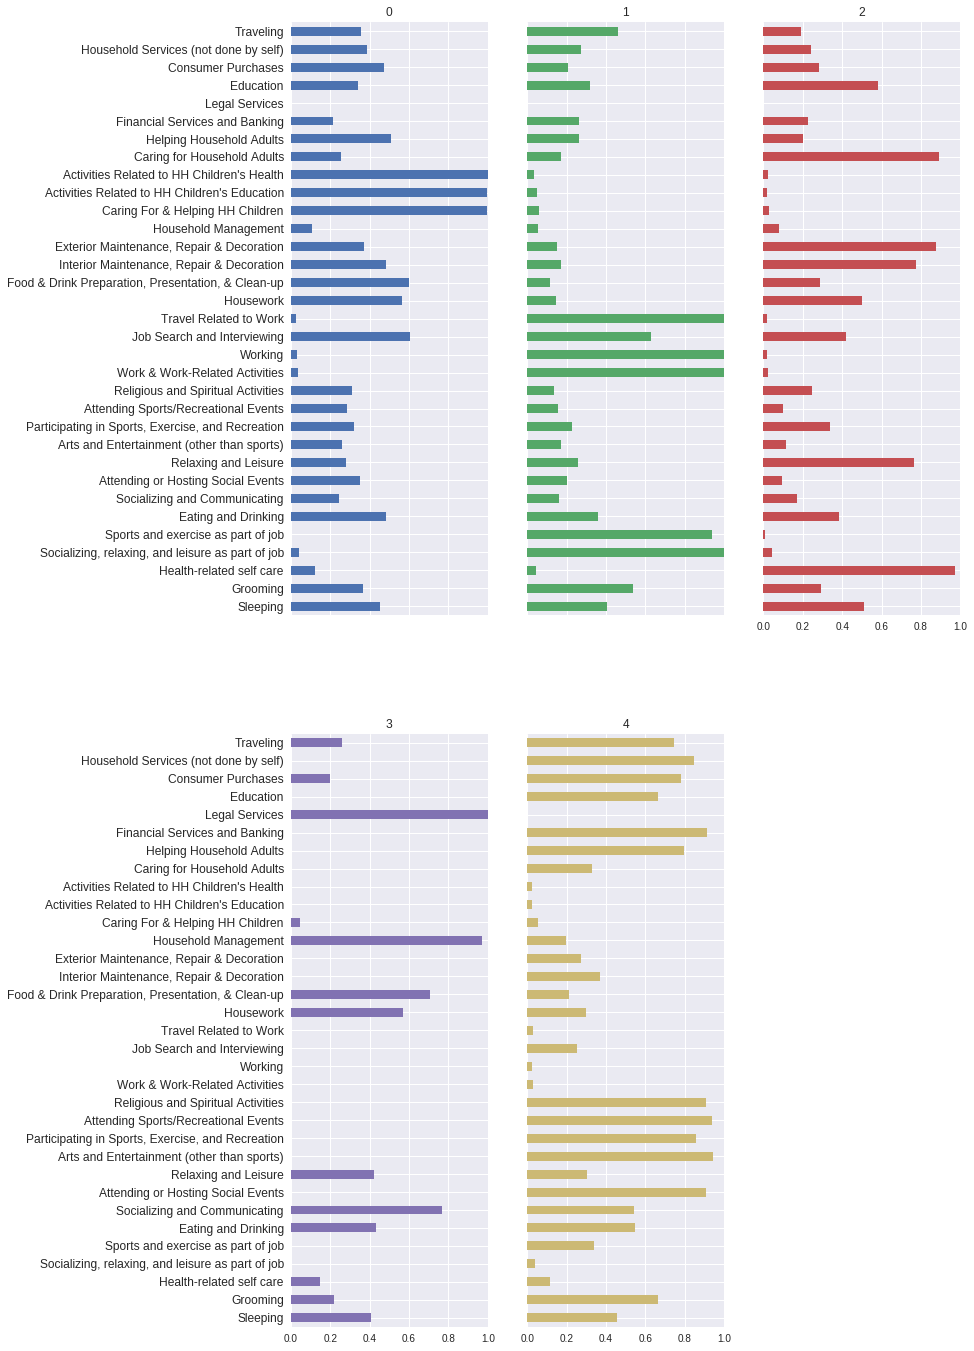

In [39]:
plots = result_df_wehol_norm.plot(kind='barh',
                                  subplots=True,
                                  layout=(2,3),
                                  figsize=(12,24),
                                  legend=False,
                                  sharey=True)
for r in plots:
    r[0].set_yticklabels([activities_dict[a] for a in ACTINFO['activities']], fontsize=12)
    for p in r:
        p.set(xlim=[0,1])
#plt.savefig('', bbox_inches='tight')
plt.show()

In [50]:
# Export results to .csv for weekend/holiday
result_df_wehol_norm['name'] = [activities_dict_sh[a] for a in ACTINFO['activities']]

In [51]:
result_df_wehol_norm['atype'] = ['pos' for i in ACTINFO['positiveWL']] + \
                                ['nego' for i in ACTINFO['negoccWL']] + \
                                ['negh' for i in ACTINFO['neghomeWL']] + \
                                ['neut' for i in ACTINFO['neutral']]

In [52]:
result_df_wehol_norm.to_csv('data-results/wehol_result.csv', index_label='idx')

In [53]:
# Export results to .csv for weekday
result_df_weday_norm['name'] = [activities_dict_sh[a] for a in ACTINFO['activities']]

In [54]:
result_df_weday_norm['atype'] = ['pos' for i in ACTINFO['positiveWL']] + \
                                ['nego' for i in ACTINFO['negoccWL']] + \
                                ['negh' for i in ACTINFO['neghomeWL']] + \
                                ['neut' for i in ACTINFO['neutral']]

In [55]:
result_df_weday_norm.to_csv('data-results/weday_result.csv', index_label='idx')